# CREDIT CARD FRAUD FINAL REPORT

##  <font color=blue>Overview</font>

This capstone project aims at using machine learning models to learn and differentiate between fraud and legal transactions. By analyzing a variety of information such as time and transation amount from real credit card data, the model hopes to give accurate fraud predictions and therefore enhances the security of credit transactions for both customers and banks.

## <font color=blue>The Problem</font>

With ecommerce and online transactions increasing each day, credit card fraud has become a real concern for consumers as well as financial companies. According to Forbes news(1), card fraud losses actually hit $21.84 billion worldwide in 2015, which was truly alarming.

So the question I am going solve here is: given data, how accurately can I detect a fraudulent transaction? 

## <font color=blue>The Client</font>

The real-world clients could be financial companies like Chase, Capital One, American Express, Discover etc.  
* For company themselves, the early prediction of potential frauds will help prevent unnecessary financial losses by allowing them to take appropriate early actions.
* For customers, the detection features could be built into credit card apps so that when a potential fraud is detected, the customers could be alerted of the situation by texts or calls. They could then respond and communicate with card companies to solve the issues together. 

After all, who doesn’t like a reliable model/method that helps guard your bank accounts and prevent unnecessary financial losses?

##  <font color=blue>The Data</font>

The dataset is already available on Kaggle.(https://www.kaggle.com/dalpozz/creditcardfraud)

It contains transactions made by credit cards in September 2013 by European cardholders. The transactions all happened within 2 days, where there are 492 frauds out of 284, 807 transactions.(2) 
It’s in the format of .csv tabular data which has the following information:
* V1-V28: The numerical principal components obtained through PCA transformation. Original features and backgroud information are not provided due to confidentiality issues. 
* Time:  The seconds elapsed between each transaction and the first transaction in the dataset;
* Amount: Transaction amount;
* Class: The classification class. 1: fraud; 0: legal transaction.

## <font color=blue>Exploratory Data Analyisis (EDA)</font>

In [1]:
#Capstone1: Credit Card Fraud
#1.Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from statsmodels.stats.weightstats import ztest
from scipy import stats

%matplotlib inline

In [2]:
#2.1 Import data
#fn='creditcard.csv'
#Uncomment this in github 
fn='data/creditcard.csv'
df = pd.read_csv(fn)

First we want to get a general idea of what the dataset looks like, whether it has any missing values, the data format, the dimensions, simple summary stats and sample data in the beginning and at the end to decide on future steps  od data wrangling.

In [3]:
#2.2 Summary stats 
# Check missing data
df.isnull().any().sum() 

0

In [4]:
print(df.info())
print(df.shape)
print(df.columns)
print(df.describe())
print(df.head(5))
print(df.tail(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

**Summary**:

We can see that, from initial exploratory analysis: 
* None of the columns have missing data, so we don't need to clean the data. For the next part, we only need to focus our attention on dealing with outliers, if any.
* It has 284807 records in total, which is consistent with the description on Kaggle. All of the features are numerical, with only ‘Class’ in the integer format, others being float. 
* Further .shape attribute is used to confirm the dimensions of (284807, 31); and .columns attribute to confirm the column names. 
* Finally, .describe(), .head() and .tail() methods are used to inspect summary stats, and general data structures of the beginning, and the end of the data frame respectively.
* Time is not unique for each entry, which means there are multiple transactions happening at the same time in the dataset. 

Next, we are plotting a heat map to see majorly the correlations of V1-V28. Since they were pre-processed by PCA, they are supposed to be a set of linearly uncorrelated variables.

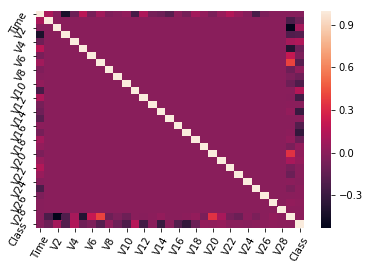

In [5]:
#Visualize correlations between all variables
sns.heatmap(df.corr())
plt.xticks(rotation=60)
plt.yticks(rotation=60)
plt.show()

The above graph confirms our previous assumption, as V1-V28 are completely uncorrelated (zero value, purple).

For the following sections, we are going to explore how these variables: PCA features, time, amount and class, distribute separately for the whole dataset. 
* PCA features: boxplot
* time: distribution plot 
* amount: boxplot
* class: summary statistics

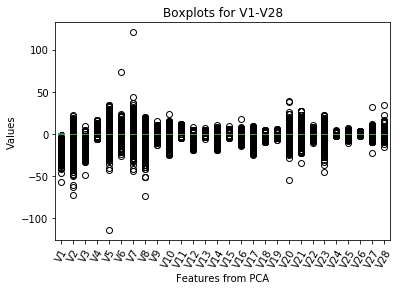

In [6]:
#By different categories: PCA features, Time, Amount, and Class(fraud or not)
#Visual EDA, PCA features plot
df_pca = df.iloc[:,1:29]
df_pca.plot(kind='Box')
plt.xticks(rotation=60)
plt.title('Boxplots for V1-V28')
plt.xlabel('Features from PCA')
plt.ylabel('Values')
plt.show()

We can see from the plot that in general, these 28 features are on the same scale of within -50 to 50. Several particularly noticeable outliers are in V5, V6, V7. Considering this is the box plot for all data including legal and fraud transactions, we will examine further later in the analysis to see where these outliers are from.

Next, we use .value_counts() on ‘Time’ column to confirm that Time is not unique, as the length reveals that there are only 124,592 unique values (as compared to 284, 807 total records). Further we are drawing a distribution plot to see whether there are any patterns in these transaction times.

count    284807.000000
mean      94813.859575
std       47488.145955
min           0.000000
25%       54201.500000
50%       84692.000000
75%      139320.500000
max      172792.000000
Name: Time, dtype: float64
124592


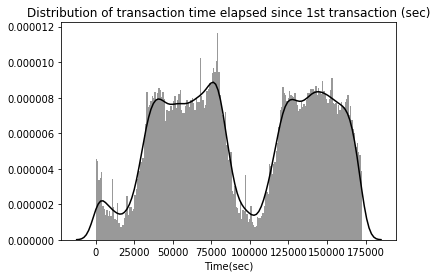

In [7]:
#EDA and visual EDA for time
print(df['Time'].describe())
print(len(df['Time'].value_counts())) 
plt.figure()
sns.distplot(df['Time'], bins = 200, norm_hist = True, color = 'black') 
plt.title('Distribution of transaction time elapsed since 1st transaction (sec)')
plt.xlabel('Time(sec)')
plt.show()

The plot shows us that there were certain time periods that transactions happened more frequently, considering this variable is expressed in seconds, we are creating a new column of datetime objects and another of hour for later analysis.

In [8]:
#Convert time into datetime obejct
def GetTime(time):
    sec = timedelta(seconds=time)
    d = datetime(1,1,1) + sec
    return d  
    #"%d:%d:%d:%d" % (d.day-1, d.hour, d.minute, d.second)      
df_newtime = [GetTime(time) for ind, time in df['Time'].iteritems()]
df['Newtime'] = df_newtime 
#Extract hour information
df['hour'] = [(GetTime(time)).hour for ind, time in df['Time'].iteritems()]

Next, we are using a boxplot to visualize the distribution of transaction amounts.

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


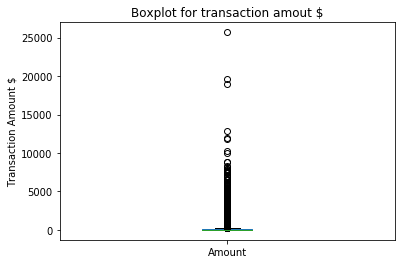

In [9]:
#EDA and visual EDA for amount 
print(df['Amount'].describe())
plt.figure()
df.plot(y='Amount', kind='box')
plt.title('Boxplot for transaction amout $')
plt.ylabel('Transaction Amount $')
plt.show()

We can see there are some outliers with really big values in this feature, and we’ll examine it further in the analysis.

For ‘Class’, since Class == 1 denotes the fraud transaction, we can use .sum() to confirm the total number of frauds within the dataset. As it turns out, there are 492 frauds in the whole dataset, which constitutes only 0.172% of all transactions, making it a very unbalanced dataset. 

In [10]:
#Class ==1:fraud. Confirm the number of frauds in the dataset.(Expected: Inbalanced)
fnum = df['Class'].sum()
fperc = float(fnum)/len(df['Class'])
print(fperc)

0.001727485630620034


It will make sense to investigate all variables again separately based on the fraud/legal status, as they will certainly contain features that help distinguish a fraud transaction and a legal one. 

In [11]:
#2.3 EDA comparing fraud vs. legal transactions 
frauds=df[df['Class']==1]
legals=df[df['Class']==0]

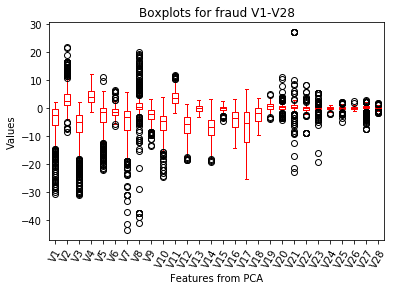

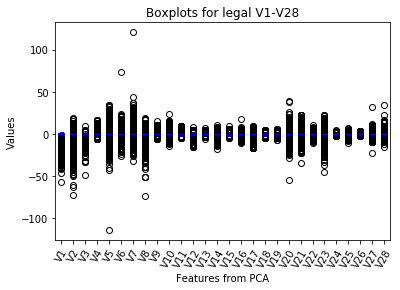

In [12]:
#V1-V28, boxplots for fraud and legal transactions 
frauds.iloc[:,1:29].plot(kind='Box', color = 'red')
plt.xticks(rotation=60)
plt.title('Boxplots for fraud V1-V28')
plt.xlabel('Features from PCA')
plt.ylabel('Values')
plt.show()
plt.savefig('Boxplots for fraud V1-V28.png')
legals.iloc[:,1:29].plot(kind='Box', color = 'blue')
plt.xticks(rotation=60)
plt.title('Boxplots for legal V1-V28')
plt.xlabel('Features from PCA')
plt.ylabel('Values')
plt.show()

As V1-V28 of fraud transactions show relatively (but not absolutely) more variations and therefore more dispersed winthin itself than legal transactions. However, as we can see here, the extremely big outliers that we spotted earlier in the whole dataset(V5, V6, V7) are actually from legal transactions.

Further, we are plotting each of the PCA features in an individual distribution plot to see visually how the feature differ between fraud and legal transactions, with red indicating ‘fraud’ and blue ‘legal’.

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


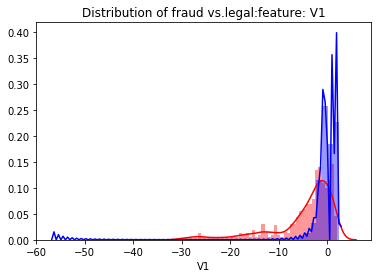

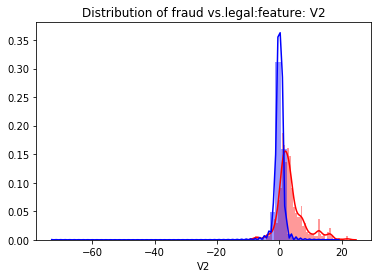

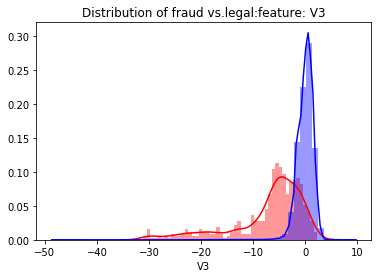

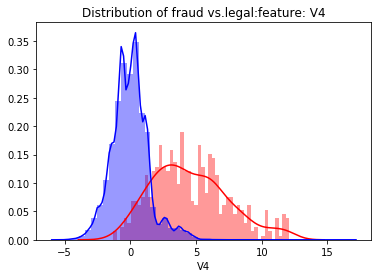

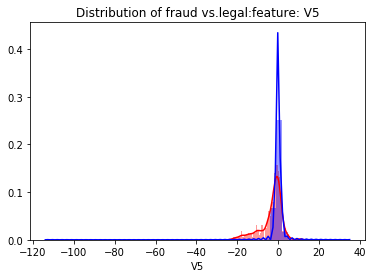

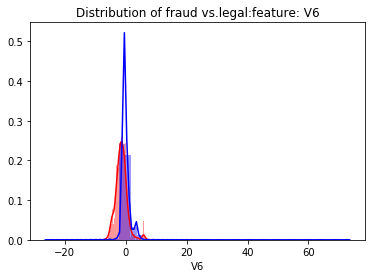

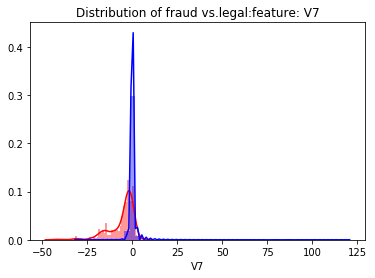

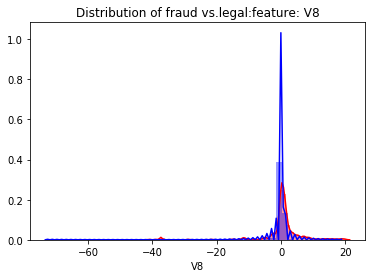

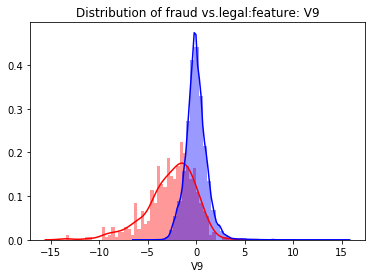

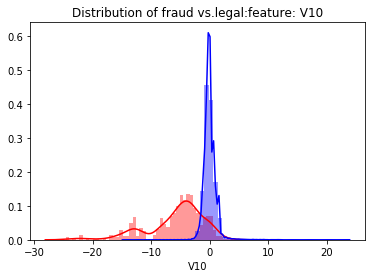

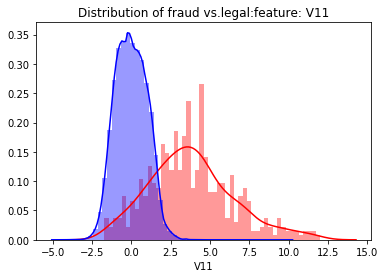

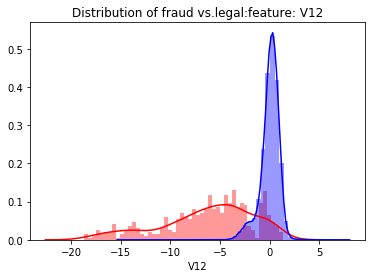

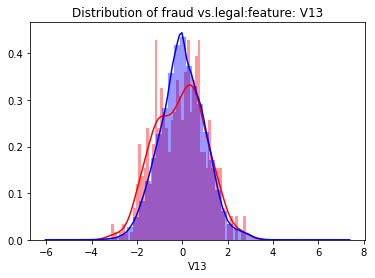

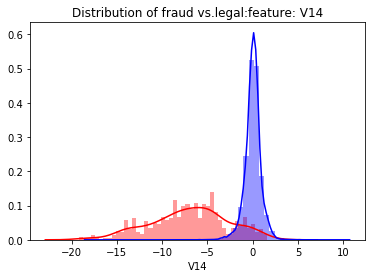

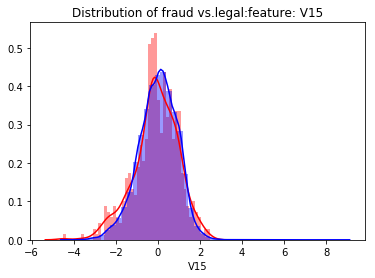

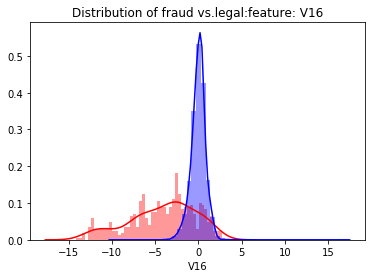

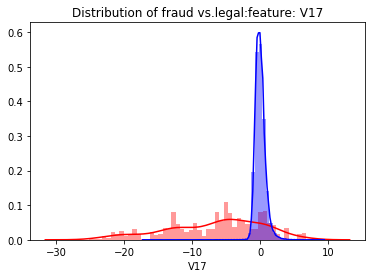

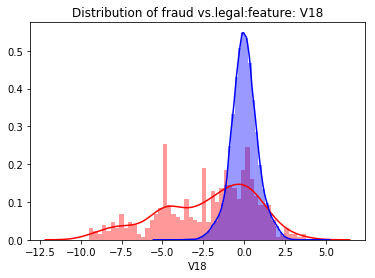

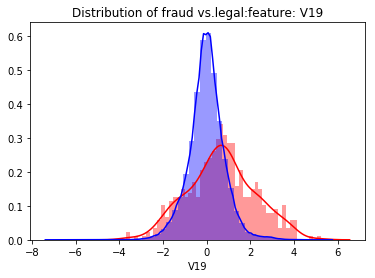

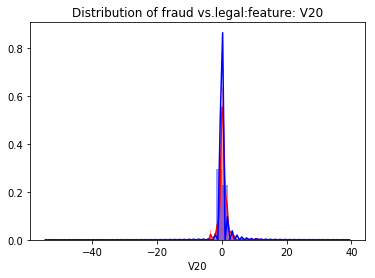

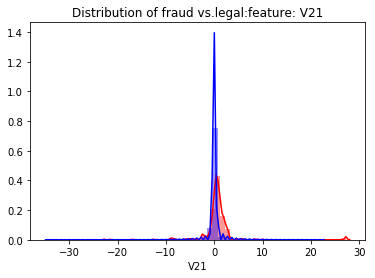

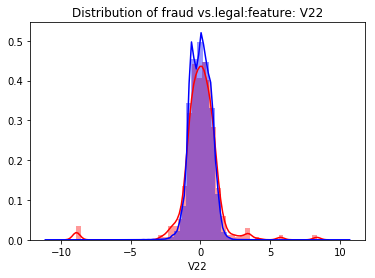

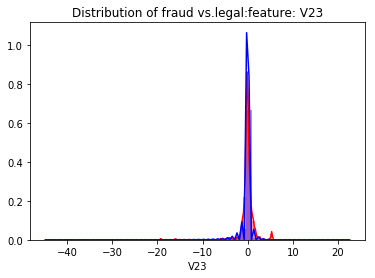

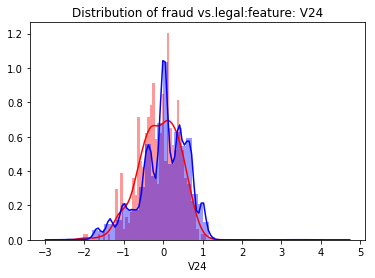

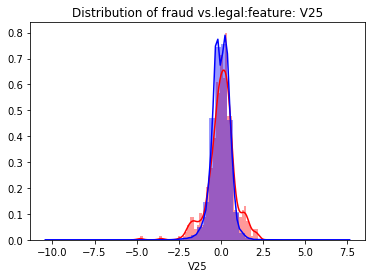

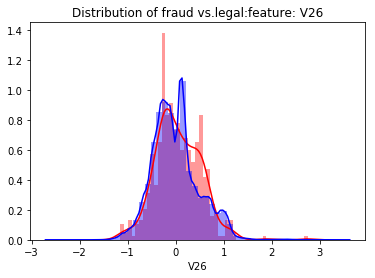

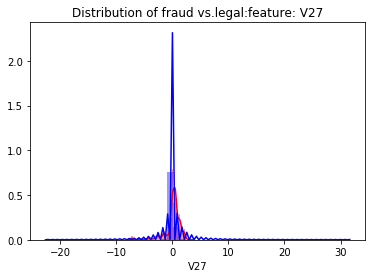

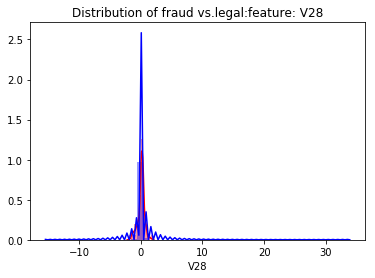

In [13]:
#Iterate through the 28 features and compare distibution for each fraud&legal pair
pca_names = df_pca.columns
print(pca_names)
for i, V in enumerate(df[pca_names]):
    plt.figure(i+1)
    sns.distplot(frauds[V], bins = 50, norm_hist = True, color = 'red')
    sns.distplot(legals[V], bins = 50, norm_hist = True, color = 'blue')
    plt.title('Distribution of fraud vs.legal:feature: ' + str(V))
    plt.show()
    plt.savefig(str(V)+'.png')
    plt.close()

These plots confirm our previous conclusion that, while legal transactions spread over a larger range in general, it has relatively much narrower peak range.

Transaction time histograms are also compared between fraud (red) and legal (blue) in original 'Time' variable, and  in 'hour' variable that we created earlier.

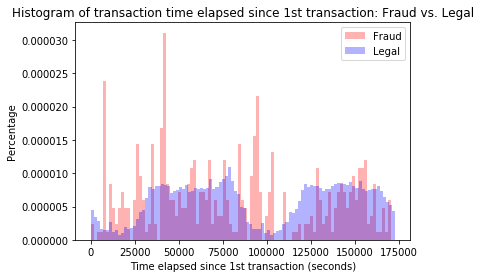

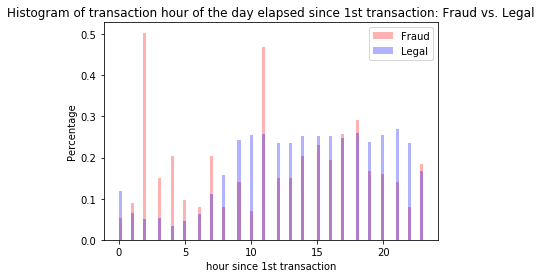

In [14]:
#Time, distribution plots for fraud vs. legal 
plt.figure()
frauds.Time.plot(kind='hist', bins=100, color = 'red', normed= True,label= 'Fraud', alpha = 0.3)
legals.Time.plot(kind='hist', bins=100, color = 'blue', normed= True, label= 'Legal',alpha = 0.3)
plt.legend(loc='upper right')
plt.title('Histogram of transaction time elapsed since 1st transaction: Fraud vs. Legal')
plt.xlabel('Time elapsed since 1st transaction (seconds)')
plt.ylabel('Percentage')
plt.show()
plt.savefig('Fraud vs. Legal Transaction Time.png')
#Check the hours 
plt.figure()
frauds.hour.plot(kind='hist', bins=100, color = 'red', normed= True,label= 'Fraud', alpha = 0.3)
legals.hour.plot(kind='hist', bins=100, color = 'blue', normed= True, label= 'Legal',alpha = 0.3)
plt.legend(loc='upper right')
plt.title('Histogram of transaction hour of the day elapsed since 1st transaction: Fraud vs. Legal')
plt.xlabel('hour since 1st transaction')
plt.ylabel('Percentage')
plt.show()

Both of the plots tell us that fraud transactions peak when the legal ones are low. We don’t have detailed time (24-hour clock) of the day of when the first transaction happened to calculate these transaction hours, but it would be logical to assume that these fraud transactions probably happen more frequently at late night and/or early morning when legal transactions are normally low.

Finally, we compare the transaction amounts for fraud and legal transactions in both .describe() function and a side by side graph.

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


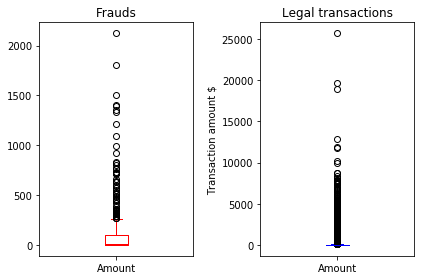

In [15]:
#Amount,summary stats and plots for fraud vs. legal 
print(frauds.Amount.describe())
print(legals.Amount.describe())
plt.figure()
plt.subplot(1,2,1)
frauds.Amount.plot(kind='Box',color = 'red')
plt.title('Frauds')
plt.subplot(1,2,2)
legals.Amount.plot(kind='Box',color = 'blue')
plt.title('Legal transactions')
plt.ylabel('Transaction amount $')
plt.tight_layout()
plt.show()

Fraud transactions are all much higher than zero (which is logical), and disperse throughout around 250 to 2000. Further, even though legal transactions have some extremely large values, the fraud transactions has a higher average (122 vs. 88) as can be obtained from the summary stats. 

## <font color=blue>Inferential Statistics</font>

Further, we carry out hypothesis testing comparing statstics between fraud and legal transactions. The specific tests will be performed are:
* z-tests for V1-V28. The null hypothesis would be h0: fraud and legal transactions have the same mean PCA.
* K-S test for Time. The null hypothesis would be h0: fraud and legal time are from the same distribution.
* Bootstrap test for Amount. The null hypothesis would be h0: fraud and legal transactions have the same mean amount.

In [16]:
#2.4 Hypothesis testing
#z-test for V1-V28 features
#legal vs. fraud
#significant level 99%. Null Hypothesis: Vi fraud = Vi legal 
#any p< 0.10 will reject the null hypothesis 
for col in pca_names:
    p1 =  frauds[col]
    p0 = legals[col]
    z_cal, p_cal= ztest(x1=p1, x2=p0, value=0, alternative='two-sided', usevar='pooled', ddof=1)
    print(col,'statistically significant difference' if p_cal < 0.01 else 'statistically insignificant difference')

V1 statistically significant difference
V2 statistically significant difference
V3 statistically significant difference
V4 statistically significant difference
V5 statistically significant difference
V6 statistically significant difference
V7 statistically significant difference
V8 statistically significant difference
V9 statistically significant difference
V10 statistically significant difference
V11 statistically significant difference
V12 statistically significant difference
V13 statistically insignificant difference
V14 statistically significant difference
V15 statistically insignificant difference
V16 statistically significant difference
V17 statistically significant difference
V18 statistically significant difference
V19 statistically significant difference
V20 statistically significant difference
V21 statistically significant difference
V22 statistically insignificant difference
V23 statistically insignificant difference
V24 statistically significant difference
V25 statistically

In [17]:
#K-S test for time(both Time and hour)
ks_cal1, p_cal1=stats.ks_2samp(frauds.Time, legals.Time)
print('K-S statistics for Time:', ks_cal1, 'p-value:',p_cal1)
ks_cal2, p_cal2=stats.ks_2samp(frauds.hour, legals.hour)
print('K-S statistics for hour:', ks_cal2, 'p-value:',p_cal2)

K-S statistics for Time: 0.16938909937434854 p-value: 8.357813751103828e-13
K-S statistics for hour: 0.1935411727716982 p-value: 1.3815502491489748e-16


For both (original) Time and hour, the p-values are small enough to reject the null hypothesis that the frauds and legals have the same distribution. The results are consistant with what we've obtained earlier using visual EDA.

We then carry out a bootstrap test for amount as well to see if the difference between frauds mean and legals mean is purely due to chance. Therefore our null hypothesis h0: the mean of fraud amount = legal amount.

In [18]:
#bootstrapping for Amount
#legal vs. fraud
#first define relevant functions:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D Data"""
    bs_sample = np.random.choice(data.values, len(data))

    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

p-value = 0.003200


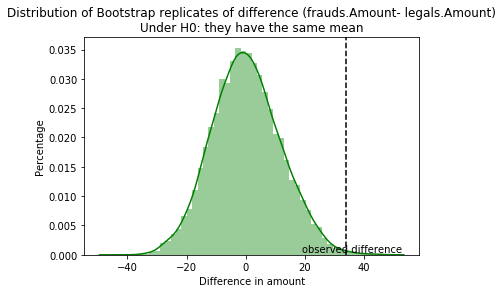

In [19]:
#Hypothesis testing: significant level alpha =0.01, Null Hypthesis: they have the same mean
mean_amount = np.mean(df.Amount.values)
obs_diff_mean = np.mean(frauds.Amount.values) - np.mean(legals.Amount.values)

frauds_shifted = frauds.Amount - np.mean(frauds.Amount.values) + mean_amount
legals_shifted = legals.Amount - np.mean(legals.Amount.values) + mean_amount

bs_replicates_frauds = draw_bs_reps(frauds_shifted, np.mean, 10000)
bs_replicates_legals = draw_bs_reps(legals_shifted, np.mean, 10000)

bs_replicates = bs_replicates_frauds - bs_replicates_legals

# Compute and print p-value: p
p = np.sum(bs_replicates >= obs_diff_mean) / len(bs_replicates)        #because obs_diff_mean= 33.92
print('p-value =', format(p, '.6f'))                                  

#visualize the bootstrap replicates results
sns.distplot(bs_replicates, bins = 50, norm_hist = True, color = 'green')
plt.axvline(x=obs_diff_mean, color='k', linestyle='--')
plt.text(obs_diff_mean-15, 0.0005, 'observed difference')
plt.xlabel('Difference in amount')
plt.ylabel('Percentage')
plt.title('Distribution of Bootstrap replicates of difference (frauds.Amount- legals.Amount)\nUnder H0: they have the same mean')
plt.show()

As we can see here, the difference in means of fraud transactions and legal transactions is highly unlikely due to chance, as p-value for getting a observed difference of ~33.92 or more extreme is 0.000000.

**Summary:**

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. * * Highly unbalanced, frauds (class ==1) only account for 0.172% of all transactions.
* No missing value is present as concluded from EDA, and therefore there is no need for cleaning the data. 
* V1-V28 were preprocessed by PCA to maintain confidentiality of sensitive information and therfore PCA features outliers, if any, are not completely meaningless. For the outliers in the amount, we see that outliers almost exclusively come from legal transactions. Depending on linearity of models built later, I will decide on whether to remove the outliers or not on a case-by-case basis.
* V1-V28, time(hour) and amount in general, all demonstrate different stats properties (mean, std, distribution etc.) in fraud and legal transactions, so it would be reasonable to include them in the prediction model. 

## <font color=blue>Predictive Modeling</font>

In [20]:
#Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
#from sklearn.pipeline import Pipeline
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report 
from sklearn.metrics import average_precision_score

In [21]:
#rearrange the columns and get rid of useless columns
cols = df.columns.tolist()
cols = cols[1:-3]+[cols[-1]]+ [cols[-3]]
print(cols)
df_1 = df[cols]
print(df_1.head(2))
#preparing training and testing for all later models
#won't hurt to scale, so I'm just scaling for all
X = df_1.iloc[:, :-1].values
y = df_1.iloc[:, -1].values
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
print('training dataset shape: ' + str(X_train.shape))
print(X_train[100],y_train[100]) #see an example of training data

['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'hour', 'Class']
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   

         V8        V9       V10  ...         V22       V23       V24  \
0  0.098698  0.363787  0.090794  ...    0.277838 -0.110474  0.066928   
1  0.085102 -0.255425 -0.166974  ...   -0.638672  0.101288 -0.339846   

        V25       V26       V27       V28  Amount  hour  Class  
0  0.128539 -0.189115  0.133558 -0.021053  149.62     0      0  
1  0.167170  0.125895 -0.008983  0.014724    2.69     0      0  

[2 rows x 31 columns]
training dataset shape: (213605, 30)
[ 0.63597216  0.10111697  0.32204781  0.44871611 -0.407737   -0.7589104
  0.01208695 -0

In [22]:
# MODEL 1: SVM
"""
param_dist = {"C":[0.1,1,10],
              "kernel":['poly','rbf', 'sigmoid'],
              "gamma":[0.01,0.02, 0.03, 0.05, 0.1]}
svm = SVC()
svm_cv = GridSearchCV(svm, param_dist, cv=5)
svm_cv.fit(X_train,y_train)

print("Tuned SVM Parameters: {}".format(svm_cv.best_params_))
print("Best score is {}".format(svm_cv.best_score_))
#Tuned SVM Parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
#Best score is 0.999499075396
"""
#Tuned SVM Parameters: {'kernel': 'rbf', 'C': 10, 'gamma': 0.01}
#Best score is 0.999499075396
#Took too long so here is the direct result 

'\nparam_dist = {"C":[0.1,1,10],\n              "kernel":[\'poly\',\'rbf\', \'sigmoid\'],\n              "gamma":[0.01,0.02, 0.03, 0.05, 0.1]}\nsvm = SVC()\nsvm_cv = GridSearchCV(svm, param_dist, cv=5)\nsvm_cv.fit(X_train,y_train)\n\nprint("Tuned SVM Parameters: {}".format(svm_cv.best_params_))\nprint("Best score is {}".format(svm_cv.best_score_))\n#Tuned SVM Parameters: {\'kernel\': \'rbf\', \'C\': 10, \'gamma\': 0.01}\n#Best score is 0.999499075396\n'

confusion matrix: [[71076     6]
 [   26    94]]


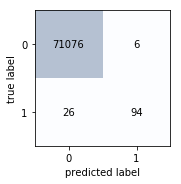

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.94      0.78      0.85       120

avg / total       1.00      1.00      1.00     71202



In [26]:
# Using tuned parameters from GridSearch Cross Validation
svm_b = SVC(kernel = 'rbf', C= 10, gamma= 0.01, probability=True, random_state = 0)
svm_b.fit(X_train, y_train)
y_pred = svm_b.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print('confusion matrix: '+str(cm))
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print(classification_report(y_test, y_pred))

[0.00045904 0.00060946 0.00021256 0.0001302  0.00035155 0.0002489
 0.00015761 0.00061722 0.00041284 0.00019808]
0

 test auc: 0.9381004801965804


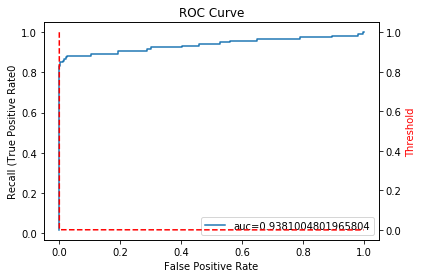

In [54]:
#mini-function to plot ROC_AUC curve
def auc_plot(y_real, y_cal):
    fpr, tpr, th = roc_curve(y_real,  y_cal)
    auc = roc_auc_score(y_real, y_cal)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall (True Positive Rate0')
    #plt.show()
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, th, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    plt.show()

y_pred_prob = svm_b.predict_proba(X_test)[:,1]
print(y_pred_prob[:10])
print(y_test[1])    
auc = roc_auc_score(y_test, y_pred_prob)
print("\n test auc:", auc)
auc_plot(y_test, y_pred_prob)

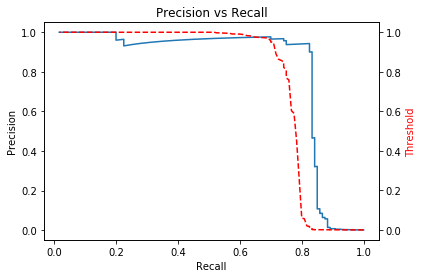

In [52]:
# mini-function plot precision-recall curve
def pre_recall_plot(y_test, y_cal):
    preci, reca, th = precision_recall_curve(y_test, y_cal)
    #print(len(reca)) 1 more length than threshold
    #print(len(preci)) 1 more length than threshold
    #print(len(th))
    plt.plot(reca[:-1], preci[:-1], label='Precision-Recall curve')
    plt.title('Precision vs Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    ax2 = plt.gca().twinx()
    ax2.plot(reca[:-1], th, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    plt.show()   

pre_recall_plot(y_test, y_pred_prob) 

Recall measures: how many true positives (fraud) are actually predicted as positives.
Precision measures: how many predicted positives are actually positives(fraud). 
So for a fraud detection model, our principle should be to detect all possible frauds (highest possible recall) and at the same time reasonably high proportion of frauds among those predicted as frauds. 

The confusion matrix gives us the predicted class results, and the classification report gives us the result metrics weighted by support (the number of true instances for each label). As we can see here, SVM classifier with tuned parameters gives us an average 0.78 recall and 0.94 precision, which means approximately among 100 true frauds, 78 can be detected; and among 100 frauds alerted by the model, 94 of them are actual frauds.

The ROC and Precision-Recall curve gives us a direct view of how those metrics change with different threshold settings.(3)(4)(5) So in general, we want to set a threshold that result in best possible recall and precision. For ROC curve, the optimal point should be upper left corner (high recall, and low False positive rate); for Precision-Recall curve, the optimal point should be upper right corner(high recall and high precision).From both graph, we can see that they involve setting a possible low threshold (<0.2).

In [55]:
#Model 1 ver2: just curious what if we drop PCA feautures that are statistically insiginificant (in EDA) and build the SVM again?
df_2 = df_1.drop(['V13', 'V15', 'V22','V23','V25','V26'], axis=1) 
X_2 = df_2.iloc[:, :-1].values
y_2 = df_2.iloc[:, -1].values
X_2 = sc.fit_transform(X_2) 
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.25, random_state = 0)

[[71076     6]
 [   27    93]]


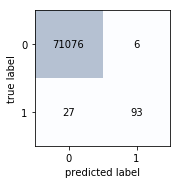

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.94      0.78      0.85       120

avg / total       1.00      1.00      1.00     71202



In [58]:
svm_2 = SVC(kernel = 'rbf', C= 10, gamma= 0.01, probability= True, random_state = 0)
svm_2.fit(X_train_2, y_train_2)
y_pred_2 = svm_2.predict(X_test_2)

cm = confusion_matrix(y_test_2, y_pred_2)
print(cm)
plt.figure()
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print(classification_report(y_test_2, y_pred_2))


 test auc: 0.913351833094173


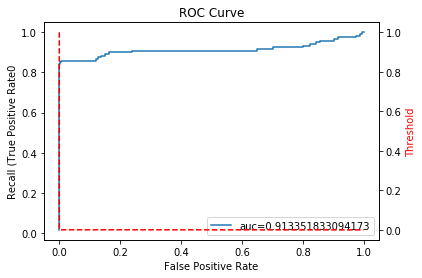

In [60]:
y_pred_prob_2 = svm_2.predict_proba(X_test_2)[:,1]
auc = roc_auc_score(y_test_2, y_pred_prob_2)
print("\n test auc:", auc)
auc_plot(y_test_2, y_pred_prob_2)

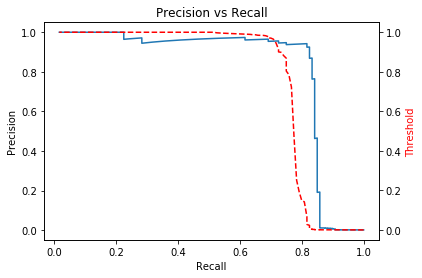

In [61]:
pre_recall_plot(y_test_2, y_pred_prob_2)

Confusion matrix, classification report, and also ROC and Precision-Recall curve all tell us that the results don't improve much (test auc slightly drops to 0.91 from 0.94 while support weighted recall and precision approximately stays the same), so there is no need to further reduce the features.

In [69]:
#Model 1 ver3: SVM, with SMOTE oversampling
sm = SMOTE(ratio ='minority', kind = 'svm', random_state=0)
X_sm, y_sm = sm.fit_sample(X_train, y_train)

[[71040    42]
 [   24    96]]


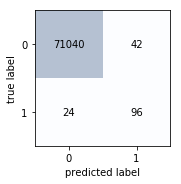

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.70      0.80      0.74       120

avg / total       1.00      1.00      1.00     71202



In [70]:
svm_sm = SVC(kernel = 'rbf', C= 10, gamma= 0.01, probability = True, random_state = 0)
svm_sm.fit(X_sm, y_sm)
y_pred_sm = svm_sm.predict(X_test)

cm = confusion_matrix(y_test, y_pred_sm)
print(cm)
plt.figure()
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print(classification_report(y_test, y_pred_sm))


 test auc: 0.949479884734063


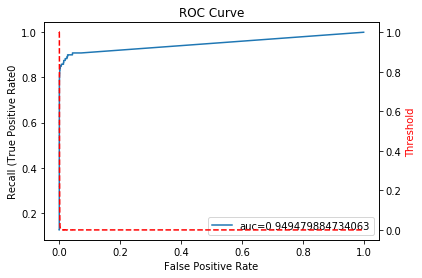

In [71]:
y_pred_sm_prob = svm_sm.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_sm_prob)
print("\n test auc:", auc)
auc_plot(y_test, y_pred_sm_prob)

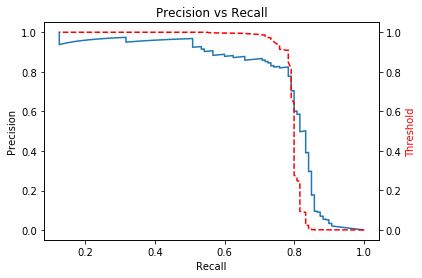

In [72]:
pre_recall_plot(y_test, y_pred_sm_prob)

We oversample the fraud class of the training data using SMOTE to adjust the class distribution of a dataset. 

As we can see from the confusion matrix and classification report, SVM gives a weighted recall of 0.80 (slightly better than our tuned SVM model), but precision (0.70) gets much lower than tuned SVM (which means for 100 fraud predictions, only 70 are actual frauds, the rest are all false alarms)for the test dataset. So overall, the improved recall might not justify the results.

ROC and Precision-Recall curves also confirm the same conclusions.

Also we should keep in mind that we might introduce other biases because of these synthetic minority samples for training,so we need to deal with care when using oversampling. 

[[71076     6]
 [   28    92]]


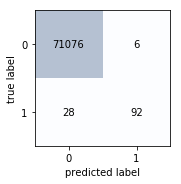

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.94      0.77      0.84       120

avg / total       1.00      1.00      1.00     71202



In [75]:
#Model 2: Random Forest 
rf = RandomForestClassifier(n_estimators=100, n_jobs= -1, random_state=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure()
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print(classification_report(y_test, y_pred))


 test auc: 0.9442724013580559


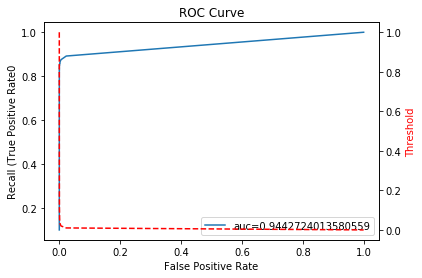

In [76]:
y_pred_prob = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
print("\n test auc:", auc)
auc_plot(y_test, y_pred_prob)

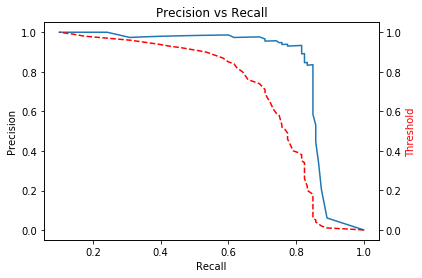

In [77]:
pre_recall_plot(y_test, y_pred_prob)

Without any parameter tuning, the random forest already achieves pretty hight precision: 0.94 and recall: 0.77 with fast training time, also in the Precision-Recall curve, we can see that this classifier has the potential to achieve even higher recall without compromising too much precision(upper right corner point) as compared to tuned SVM, so it would make sense to further explore this model to see if we can get better results.

Feature ranking:
1. feature 16 (0.226517)
2. feature 13 (0.109230)
3. feature 11 (0.101886)
4. feature 10 (0.075535)
5. feature 9 (0.064392)
6. feature 15 (0.062372)
7. feature 8 (0.028741)
8. feature 6 (0.026767)
9. feature 3 (0.025334)
10. feature 25 (0.020917)
11. feature 5 (0.020553)
12. feature 20 (0.019861)
13. feature 17 (0.019368)
14. feature 2 (0.018586)
15. feature 26 (0.015291)
16. feature 0 (0.014918)
17. feature 19 (0.014256)
18. feature 7 (0.013543)
19. feature 4 (0.012374)
20. feature 1 (0.012280)
21. feature 18 (0.011743)
22. feature 21 (0.011283)
23. feature 27 (0.011265)
24. feature 28 (0.010184)
25. feature 14 (0.010149)
26. feature 12 (0.009401)
27. feature 24 (0.009125)
28. feature 23 (0.008756)
29. feature 22 (0.007999)
30. feature 29 (0.007376)


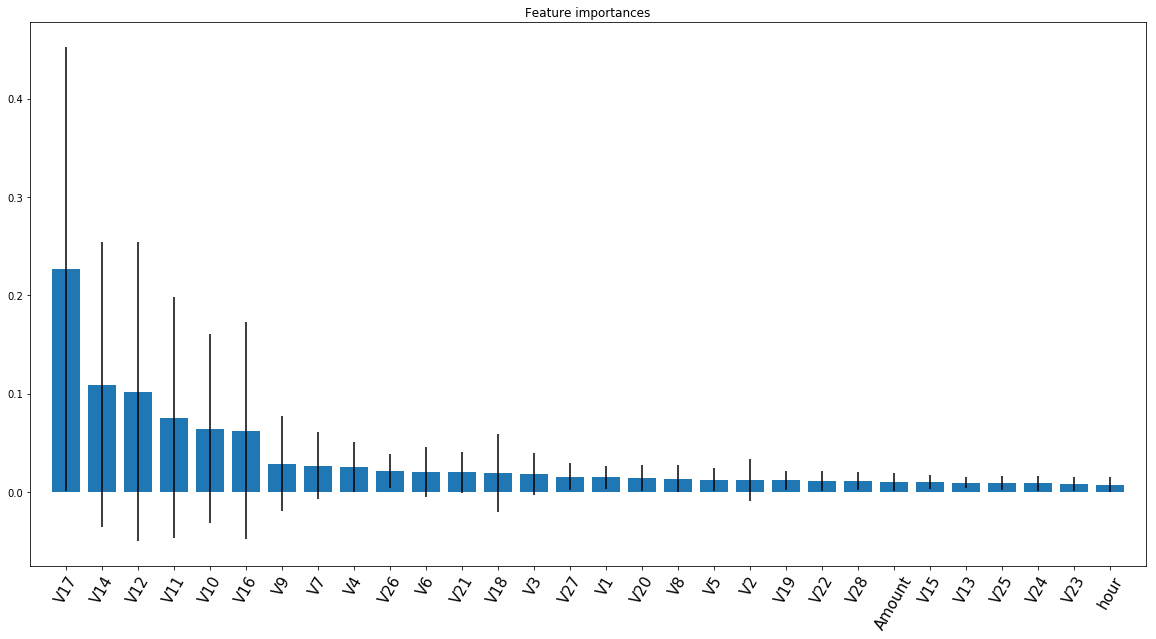

In [80]:
#Feature importances to Random Forest 
importances = rf.feature_importances_
number_to_keep = len(importances)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:number_to_keep]

print("Feature ranking:")
for f in range(len(indices)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(indices)), df_1.columns[indices], rotation=60, size=15)
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
#With parameters tuning
"""
param_dist = {"n_estimators":[10,50,100],
              "max_depth": [3,10],
              "criterion": ["gini", "entropy"]}

rf = RandomForestClassifier(n_jobs= -1, random_state=0)
rf_cv = GridSearchCV(rf, param_dist, cv=5)

rf_cv.fit(X_train,y_train)

print("Tuned Decision Tree Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))
"""
#Tuned Decision Tree Parameters: {'n_estimators': 100, 'max_depth': 10, 'criterion': 'gini'}
#Best score is 0.9995318461646497

[[71076     6]
 [   28    92]]


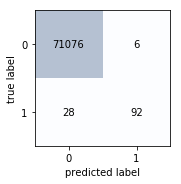

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.94      0.77      0.84       120

avg / total       1.00      1.00      1.00     71202



In [81]:
#using tuned parameters 
rf_b = RandomForestClassifier(n_estimators = 100, max_depth = 10, 
                              criterion= 'gini',n_jobs=-1, random_state = 0)
rf_b.fit(X_train, y_train)
y_pred = rf_b.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print(classification_report(y_test, y_pred))


 test auc: 0.9742915459141086


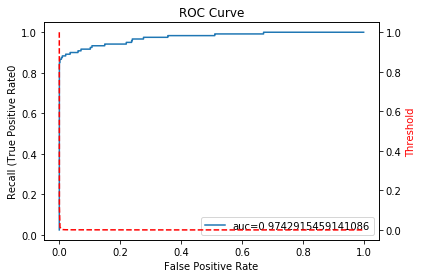

In [82]:
y_pred_prob = rf_b.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
print("\n test auc:", auc)
auc_plot(y_test, y_pred_prob)

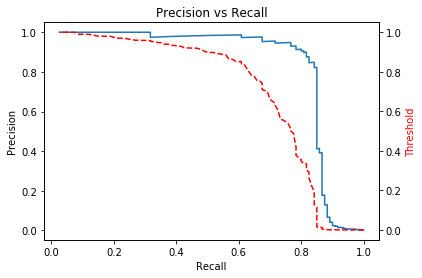

In [83]:
pre_recall_plot(y_test, y_pred_prob)

With parameter tuning, the random forest doesn't change too much on weighted recall and precision, but ROC and Precision-Recall curve slightly improve towards the ideal. Considering the overall speed of training this classifier, the tuning could be justified for better results.

In [112]:
# Model 3: A simple deep learning model
#!pip3.5 install --user np_utils
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
#from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.models import model_from_json

#define relevant metrics
def precision(y_true, y_pred):
    """Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [115]:
n_cols = X_train.shape[1]
print(n_cols)
#y_keras = y_train 
y_keras= to_categorical(y_train)
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = (n_cols,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer= 'adam', loss ='binary_crossentropy', metrics =[precision,recall])

early_stopper = EarlyStopping(patience = 2)
history = model.fit(X_train,y_keras, epochs= 50, validation_split=0.1, callbacks=[early_stopper])
#keras.callbacks.ModelCheckpoint('/Desktop', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

30
Train on 192244 samples, validate on 21361 samples
Epoch 1/50
192244/192244 [==============================] - 12s 64us/step - loss: 0.0057 - precision: 0.9990 - recall: 0.9990 - val_loss: 0.0049 - val_precision: 0.9987 - val_recall: 0.9987
Epoch 2/50
192244/192244 [==============================] - 12s 63us/step - loss: 0.0032 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.0034 - val_precision: 0.9993 - val_recall: 0.9993
Epoch 3/50
192244/192244 [==============================] - 12s 63us/step - loss: 0.0027 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.0037 - val_precision: 0.9993 - val_recall: 0.9993
Epoch 4/50
192244/192244 [==============================] - 13s 65us/step - loss: 0.0026 - precision: 0.9994 - recall: 0.9994 - val_loss: 0.0047 - val_precision: 0.9993 - val_recall: 0.9993


In [116]:
model.summary()
#save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Model saved")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 100)               3100      
_________________________________________________________________
dense_29 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
Total params: 13,402
Trainable params: 13,402
Non-trainable params: 0
_________________________________________________________________
Model saved


In [117]:
print(history.history.keys())

dict_keys(['val_loss', 'recall', 'precision', 'loss', 'val_precision', 'val_recall'])


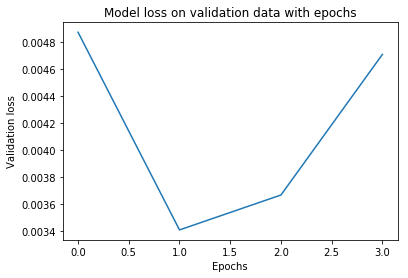

In [118]:
# plot loss on validation data
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.title('Model loss on validation data with epochs')
plt.show()

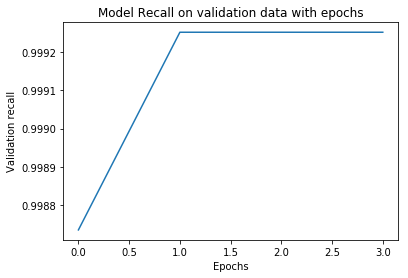

In [119]:
# plot recall on validation data
plt.plot(history.history['val_recall'])
plt.xlabel('Epochs')
plt.ylabel('Validation recall')
plt.title('Model Recall on validation data with epochs')
plt.show()

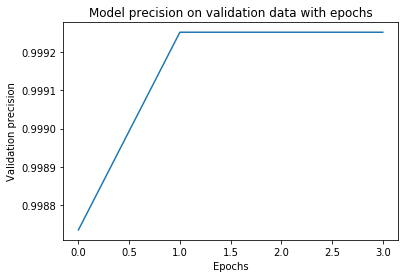

In [120]:
# plot precision on validation data
plt.plot(history.history['val_precision'])
plt.xlabel('Epochs')
plt.ylabel('Validation precision')
plt.title('Model precision on validation data with epochs')
plt.show()

[[71073     9]
 [   30    90]]


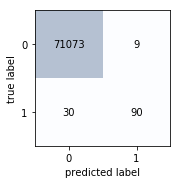

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71082
          1       0.91      0.75      0.82       120

avg / total       1.00      1.00      1.00     71202



In [121]:
y_pred = model.predict_classes(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
print(classification_report(y_test, y_pred))


 test auc: 0.9713707408345291


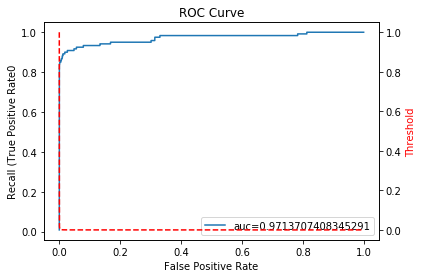

In [122]:
y_pred_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_prob)
print("\n test auc:", auc)
auc_plot(y_test, y_pred_prob)

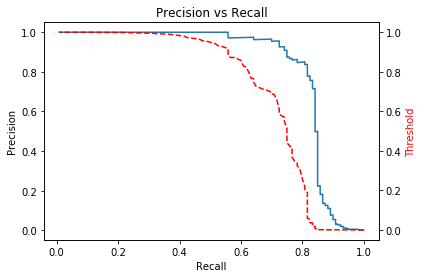

In [123]:
pre_recall_plot(y_test, y_pred_prob)

With a simple NN model, after only around 2 epochs, it achieves support weighted recall of 0.75 and precision of 0.91, with comparable ROC and Precision-Recall curve with tuned random forest and fast training time.

Overall, in terms of best results, tuned SVM out performs others.
But in terms of practical considerations of efficiency of training the model, random forests and nn model are similar in performances, so they are both apt for the detection task.

However if only one choice should be made, then I would suggest random forest as the top pick for its slightly better recall (for in real life situations we would want to capture as many frauds as possible to reduce the risk of potential financial loss, so the slight higher rate(0.2 higher) could mean a practical difference) and precision, and also ease of implementation as compared to the nn model.

The seperate code could also be found at https://github.com/chocolocked/Capstone_1_CreditCardFraud

## <font color=blue>References</font>

* (1) https://www.forbes.com/sites/rogeraitken/2016/10/26/us-card-fraud-losses-could-exceed-12bn-by-2020/#53aa8baed243

* (2) K.R., Seeja & Zareapoor, Masoumeh. (2014). FraudMiner: A Novel Credit Card Fraud Detection Model Based on Frequent Itemset Mining. TheScientificWorldJournal. 2014. 252797. 10.1155/2014/252797

* (3) https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/ 

* (4) Receiver Operating Characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic

* (5) Area under curve, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve
